In [1]:
import os
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, join
import astropy.units as u

import scipy.stats as stats

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 24,
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix'
})

def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

## SDSS+WISE catalog details

As described in Chang+15

https://irfu.cea.fr/Pisp/yu-yen.chang/sw.html

In [2]:
#download SDSS+WISE from the database

with fits.open('https://irfu.cea.fr/Pisp/yu-yen.chang/sw/sw_input.fits') as cat:
    sw_input = Table(cat[1].data)

with fits.open('https://irfu.cea.fr/Pisp/yu-yen.chang/sw/sw_output.fits') as cat:
    sw_output = Table(cat[1].data)

In [ ]:
#load SDSS+WISE from files
with fits.

In [3]:
#produce magnitude columns
SW_fluxJy_r = sw_input['flux0_r'] * u.Jansky
SW_fluxerrJy_r = sw_input['flux0_r_e']

SW_fluxJy_g = sw_input['flux0_g'] * u.Jansky
SW_fluxerrJy_g = sw_input['flux0_g_e']

SW_mag_r = SW_fluxJy_r.to(u.ABmag).value
SW_magerr_r = errJy_to_errABmag(SW_fluxerrJy_r, SW_fluxerrJy_r).value

SW_mag_g = SW_fluxJy_g.to(u.ABmag).value
SW_magerr_g = errJy_to_errABmag(SW_fluxJy_g, SW_fluxerrJy_g).value

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [4]:
#correct for extinction
SW_mag_r -= sw_input['extin_r']
SW_mag_g -= sw_input['extin_g']

In [5]:
#produce color columns
SW_gr_color = SW_mag_g - SW_mag_r
SW_gr_color_err = np.hypot(SW_magerr_g, SW_magerr_r)

/var/tmp/lsajkov/ipykernel_2470253/158097490.py:2: RuntimeWarning: invalid value encountered in subtract
  SW_gr_color = SW_mag_g - SW_mag_r


Text(0.6, 0.95, 'SDSS+WISE catalog')

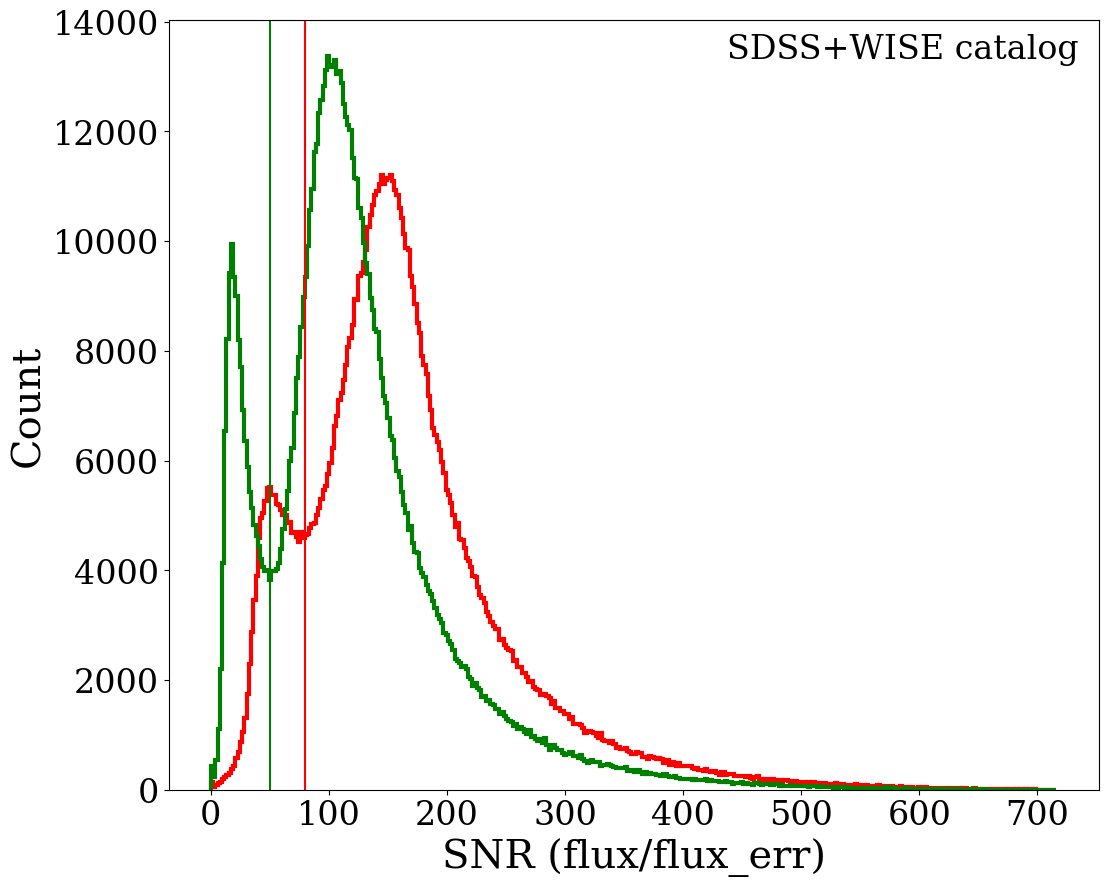

In [13]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

bins = ax.hist(sw_input['flux0_r']/sw_input['flux0_r_e'],
               bins = 'auto', histtype = 'step', color = 'red', linewidth = 3)

ax.hist(sw_input['flux0_g']/sw_input['flux0_g_e'],
        bins = bins[1], histtype = 'step', color = 'green', linewidth = 3)

ax.axvline(80, color = 'red')
ax.axvline(50, color = 'green')

ax.set_xlabel('SNR (flux/flux_err)')
ax.set_ylabel('Count')

ax.text(0.6, 0.95,
        'SDSS+WISE catalog',
        transform = ax.transAxes)

In [34]:
len(bins[1])

379

In [14]:
#quality cuts
flag_mask = sw_output['flag'] == 1
print(f'Using the recommended quality flags, {np.sum(flag_mask)}/{len(flag_mask)} (~{int(100 * np.sum(flag_mask)/len(flag_mask))}%) remain.')

snr_mask  = (sw_input['flux0_g']/sw_input['flux0_g_e'] > 50) &\
            (sw_input['flux0_r']/sw_input['flux0_r_e'] > 80)

print(f'also cutting on SNR, {np.sum(flag_mask & snr_mask)}/{len(flag_mask)} (~{int(100 * np.sum(flag_mask & snr_mask)/len(flag_mask))}%) remain.')


Using the recommended quality flags, 633205/858365 (~73%) remain.
also cutting on SNR, 618559/858365 (~72%) remain.


Text(0.01, 0.85, 'SDSS+WISE Catalog\nPhotometry flag applied\n633205/858365 sources')

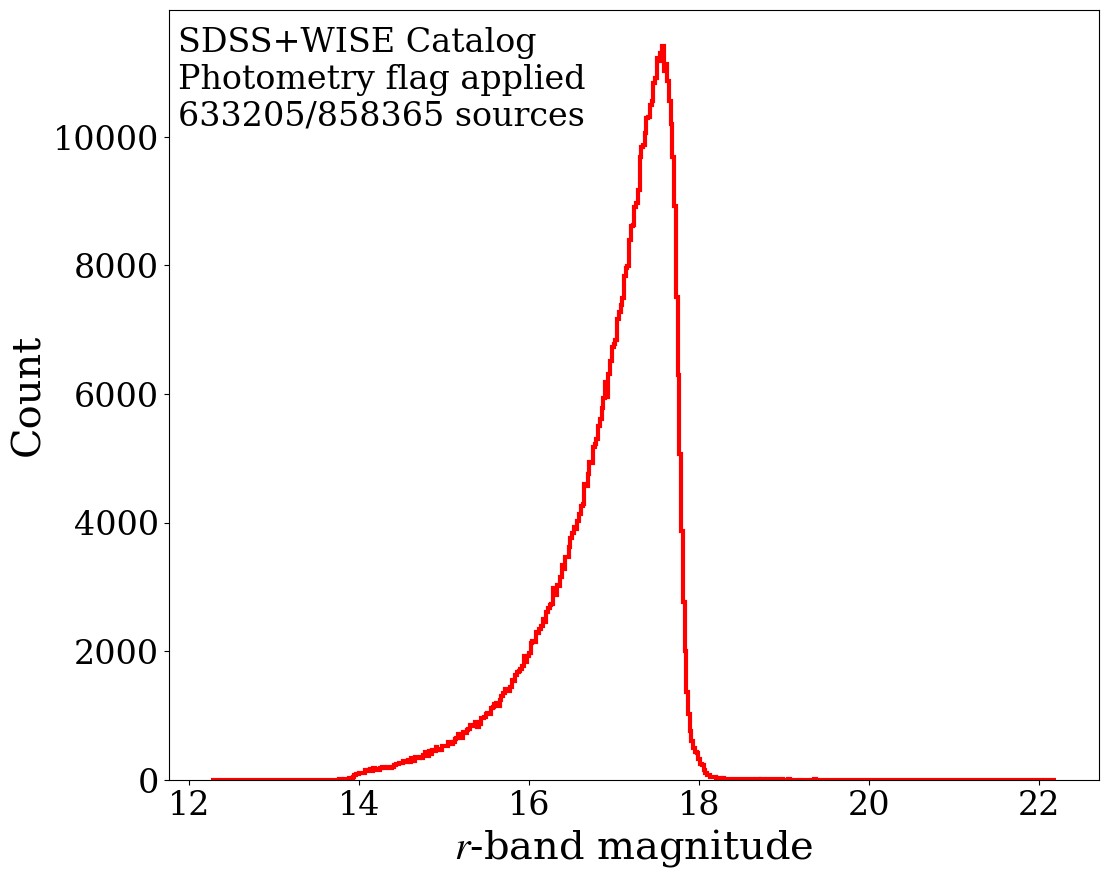

In [36]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(SW_mag_r[flag_mask],
        bins = 'auto', histtype = 'step',
        color = 'red', linewidth = 3)
ax.set_xlabel('$r$-band magnitude')
ax.set_ylabel('Count')

ax.text(0.01, 0.85,
        f'SDSS+WISE Catalog\nPhotometry flag applied\n{np.sum(flag_mask)}/{len(flag_mask)} sources',
        transform = ax.transAxes)

In [17]:
#log_mstar mask
log_mstar_mask = (6 < sw_output['lmass50_all']) &\
                 (sw_output['lmass50_all'] < 9.5)

print(f'with all applied cuts, {np.sum(flag_mask & snr_mask & log_mstar_mask)}/{len(flag_mask)} (~{int(100 * np.sum(flag_mask & snr_mask & log_mstar_mask)/len(flag_mask))}%) remain.')

with all applied cuts, 39396/858365 (~4%) remain.


In [19]:
#define primary targeting region
def gr_color_condition(gr_color, gr_color_err,
               r_mag):
    
    return (gr_color - gr_color_err + 0.06 * (r_mag - 14)) < 0.9

In [20]:
gr_color_mask = gr_color_condition(SW_gr_color,
                                   SW_gr_color_err,
                                   SW_mag_r)

/var/tmp/lsajkov/ipykernel_2470253/3416089688.py:5: RuntimeWarning: invalid value encountered in subtract
  return (gr_color - gr_color_err + 0.06 * (r_mag - 14)) < 0.9
/var/tmp/lsajkov/ipykernel_2470253/3416089688.py:5: RuntimeWarning: invalid value encountered in add
  return (gr_color - gr_color_err + 0.06 * (r_mag - 14)) < 0.9


<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_2470253/3207519153.py:18: SyntaxWarning: invalid escape sequence '\o'
  fig.colorbar(mappable = hb, label = 'Median log$(M_*/M_{\odot})$')


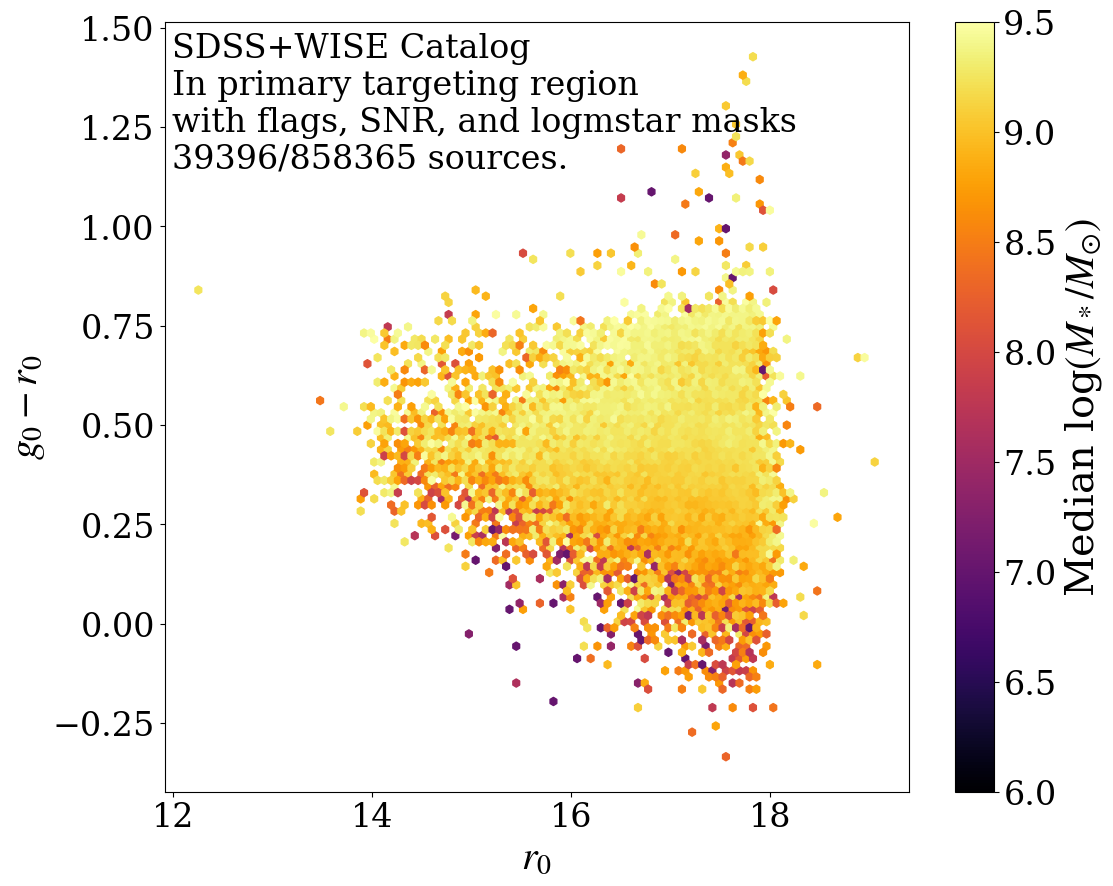

In [26]:
fig = plt.figure(figsize = (12, 10))
ax  = fig.add_subplot()

plot_idx = flag_mask & gr_color_mask & snr_mask & log_mstar_mask

hb = ax.hexbin(SW_mag_r[plot_idx], SW_gr_color[plot_idx],
               C = sw_output[plot_idx]['lmass50_all'],
               reduce_C_function = np.median,
               cmap = 'inferno',
               vmin = 6, vmax = 9.5)

ax.set_xlabel('$r_0$')
ax.set_ylabel('$g_0 - r_0$')

ax.text(0.01, 0.81,
        f'SDSS+WISE Catalog\nIn primary targeting region\nwith flags, SNR, and logmstar masks\n{np.sum(plot_idx)}/{len(plot_idx)} sources.',
        transform = ax.transAxes)
fig.colorbar(mappable = hb, label = 'Median log$(M_*/M_{\odot})$')

Text(0.28, 0.81, 'SDSS+WISE Catalog\nCuts: photometry flags, SNR, logmstar\nLimited to primary targeting region\n39396/858365')

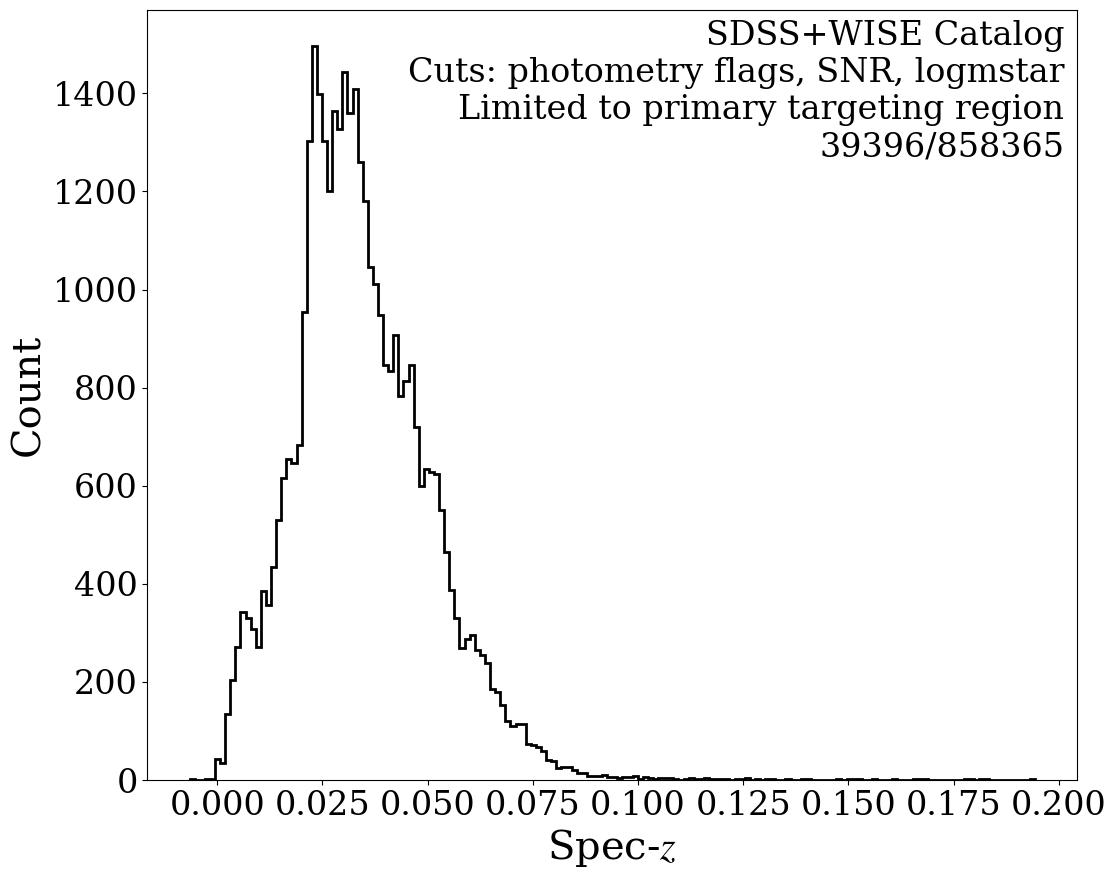

In [58]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(sw_input[plot_idx]['redshift'],
        bins = 'auto', histtype = 'step',
        color = 'black', linewidth = 2)

ax.set_xlabel('Spec-$z$')
ax.set_ylabel('Count')

ax.text(0.28, 0.81,
        f'SDSS+WISE Catalog\nCuts: photometry flags, SNR, logmstar\nLimited to primary targeting region\n{np.sum(plot_idx)}/{len(plot_idx)}',
        ma = 'right', transform = ax.transAxes)

In [ ]:
#produce additional columns

#g-r color columns
GAMA_gr_color = GAMA_mstar_concat['absmag_g'] - GAMA_mstar_concat['absmag_r']
GAMA_gr_color_err =  np.hypot(GAMA_magerr_g, GAMA_magerr_r)

#effective surface brightness column
GAMA_mu_r_eff = GAMA_mag_r + 2.5 * np.log10(2 * np.pi * GAMA_approx_fwhm ** 2)

Primary targeting region

In [11]:
sw_input['extin_r']

0.18399
0.198402
0.181997
0.193055
0.195289
0.180516
0.105177
0.100972
0.114747
0.112861
0.100848
